# Задание #3 Data Analysis

## Описание предоставленных данных
Фрейм test_price состоит из:
* Датасет - каталог товара с данными во вложении
* id: товар
* Brand:Бренд
* Category: категория
* SubCategory: подкатегория
* SellPrice: цена продажи

### Библиотеки Python

* [Pandas](http://pandas.pydata.org/)
- [Tutorials](http://pandas.pydata.org/pandas-docs/stable/tutorials.html)
- [Easier data analysis in Python with pandas](http://www.dataschool.io/easier-data-analysis-with-pandas/)

## Разминка
**Как и в предыдущей лабораторной здесь запрещено использовать циклы, если это специально не оговорено.**
1. Описательная статистика
* Вывести самый частотный бренд, категорию, подкатегорию
*  Вывести по ним размах цен
*  Вывести Среднее значение или медиану (выбор обосновать)

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import IPython.display as display
import random
from IPython.core.interactiveshell import InteractiveShell
pd.options.display.float_format = '{:.2f}'.format 
np.set_printoptions(suppress=True)
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
plt.style.use('dark_background')

In [ ]:
df = pd.read_csv('test_price.csv')
df.head()

,id,Brand,SubCategoryNr,Category,SellPrice
0,452798,79,3488,36,10.92
1,599859,79,1485,36,112.04
2,183475,79,1485,36,25.09
3,552471,79,3282,36,1.40
4,589285,79,3282,36,2.28


We'll use median price as it's a better indication than average(mean) price. Although it is less affected by outliers.

In [ ]:
def show_price(df, col):
  df_col = df.groupby([col])[col].count().nlargest(1).index[0]
  df_price = df.SellPrice[df[col] == df_col]
  price_gap = df_price.max() - df_price.min()
  return df_col, price_gap, df_price.median() 
  
df_brand, df_cat, df_sub = show_price(df, 'Brand'), show_price(df, 'Category'), show_price(df, 'SubCategoryNr')

pd.DataFrame([[*df_brand], [*df_cat], [*df_sub]], columns = ['Name', 'Price_gap', 'Median_price'], index=['Brand', 'Category', 'SubCategoryNr'])

,Name,Price_gap,Median_price
Brand,369,2712.32,16.73
Category,13,1735.56,26.03
SubCategoryNr,82,1207.98,32.16



2. Сделать график Распределения иерархий(бренд, категория, подкатегория) по ценам

• Распределение (средняя цена / бренд) - берем топ 25-35 брендов

• Распределение (средняя цена / категория) берем топ 25-35 категорий

• Распределение (средняя цена / подкатегория) берем топ 25-35 подкатегорий

**Извиняюсь за циклы. Мог бы и без них, но я просто хотел показать разные подходы.**

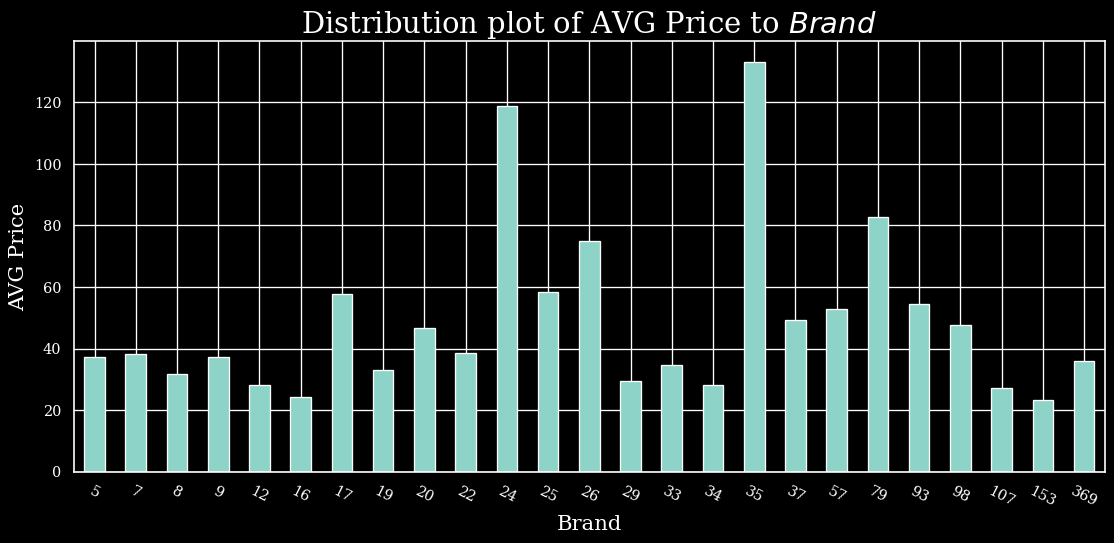

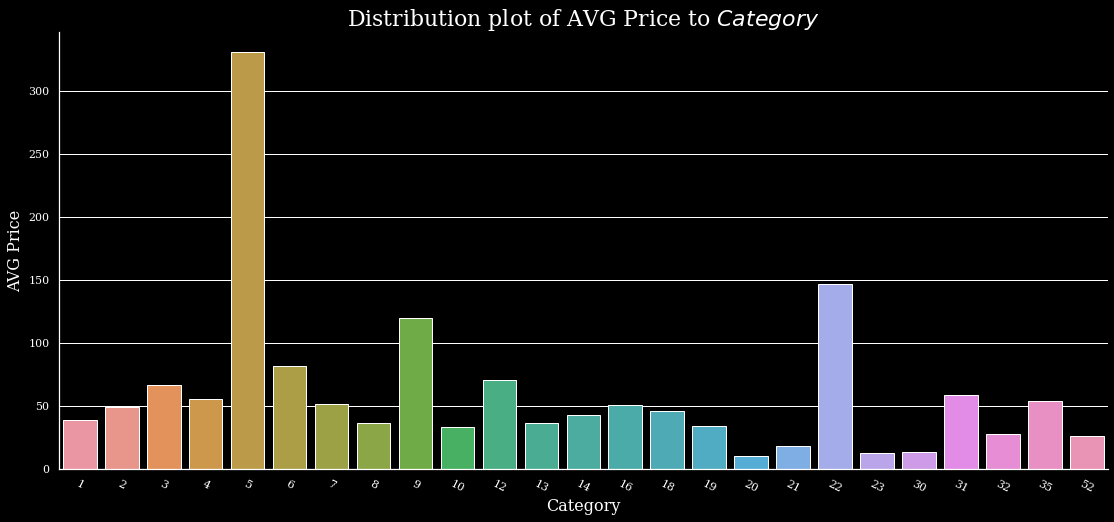

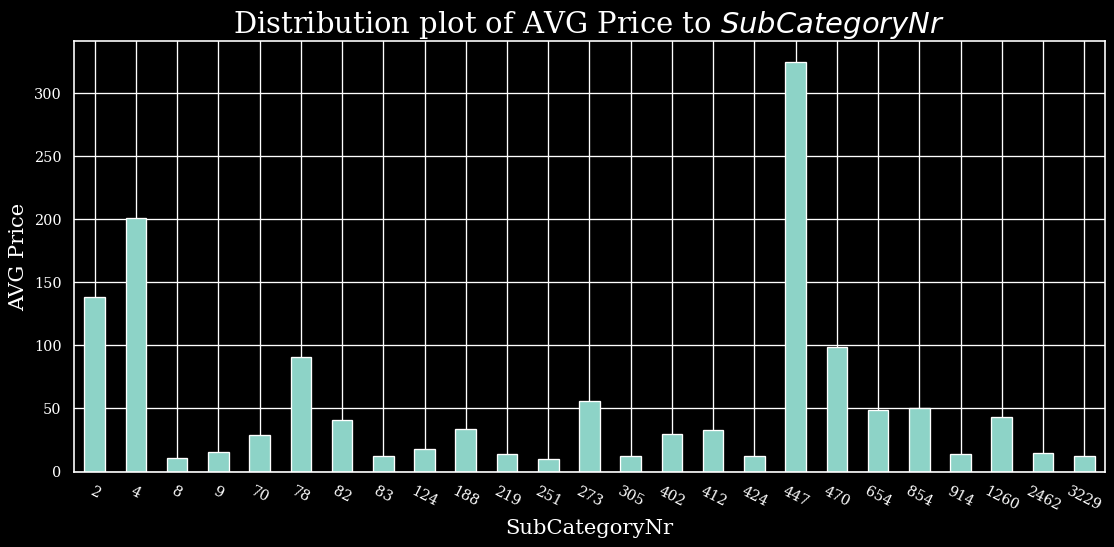

In [ ]:
def distro_plot(df, col, chart='plot'):

  df = pd.read_csv('test_price.csv')
  df_col = df.groupby([col])[col].count().nlargest(25).to_frame().rename({col: 'Count'}, axis=1).reset_index().drop(['Count'], axis=1)
  df_sales = df.groupby([col])['SellPrice'].mean().to_frame()
  df_merge = df_col.merge(df_sales, how='left', on=col)

  if chart == 'plot':
    plt.figure(figsize=(14, 6), dpi= 95)
    df_merge.groupby(col)['SellPrice'].mean().plot(kind='bar')

  elif chart == 'cat':
    df_pt = pd.pivot_table(df_merge, values='SellPrice', columns=[col])
    sns.catplot(data=df_pt, kind='bar', height=7, aspect=2.202);
  
  else: 
    print('This function is not available yet, but we\'re trying our best to deploy it!')

  font = {'family' : 'serif', 'size' : 14}
  plt.rc('font', **font)
  plt.xlabel(col, fontsize=16)
  plt.xticks(rotation = 333)
  plt.title(f'Distribution plot of AVG Price to ${col}$', fontsize=22)
  plt.ylabel("AVG Price", fontsize=16)
  plt.show();


distro_plot(df, 'Brand')
distro_plot(df, 'Category', 'cat')
distro_plot(df, 'SubCategoryNr')


3. Построить диаграмму размаха boxplot иерархий по ценам
* Также как в задание выше (бренд, категория, подкатегория)

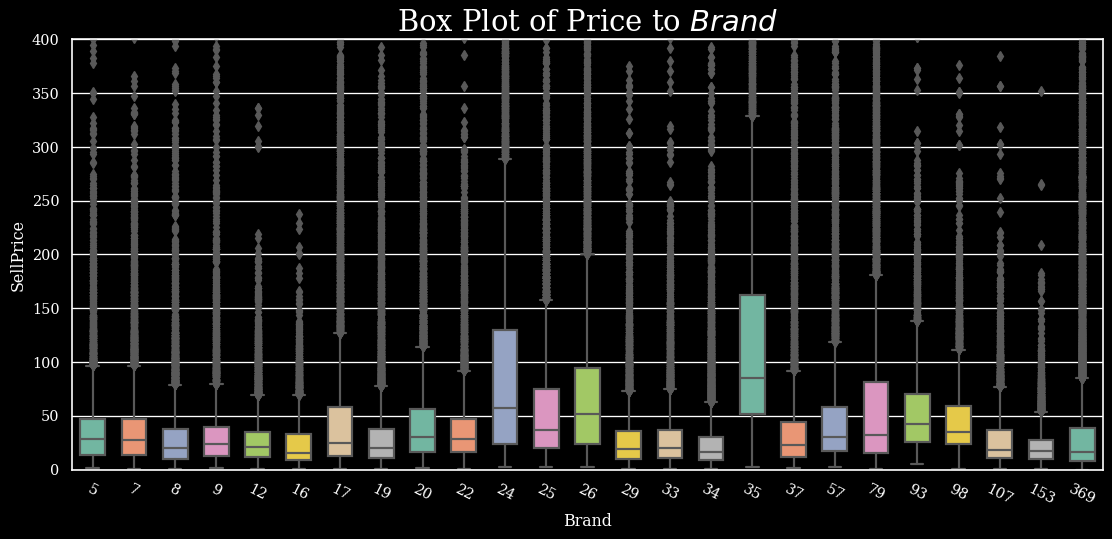

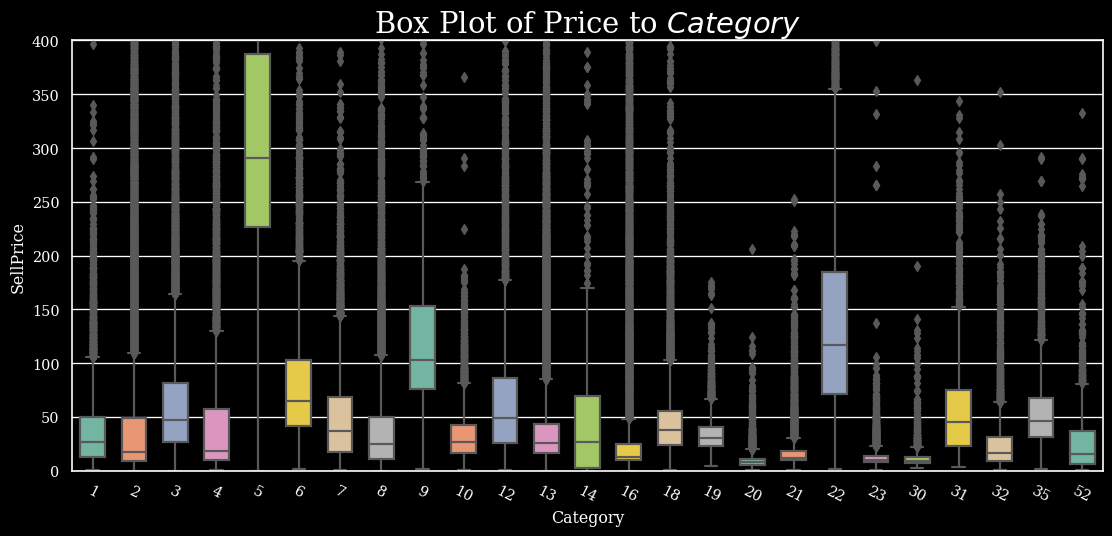

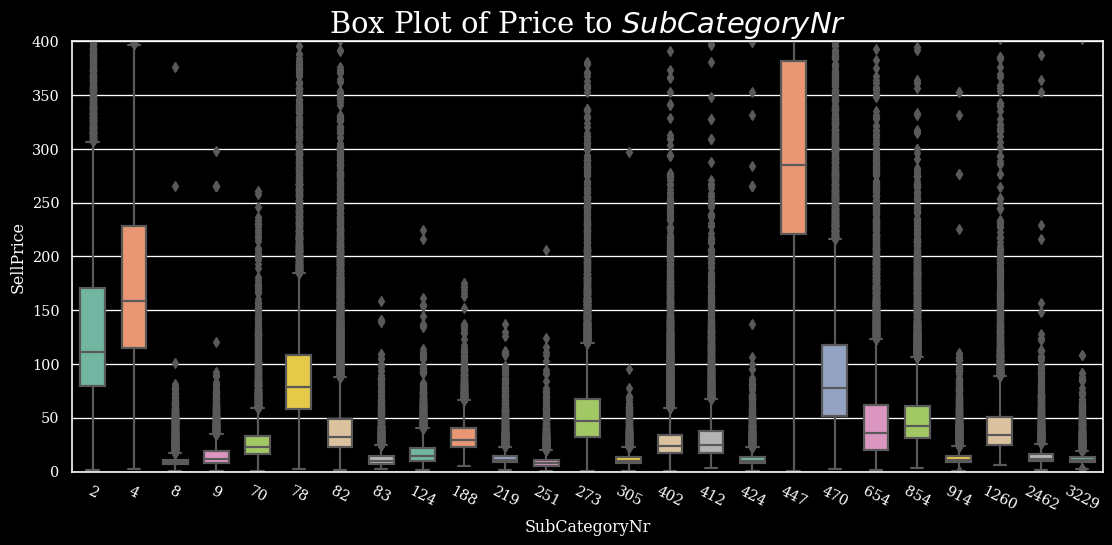

In [ ]:
def box_plot(df, col):

  df = pd.read_csv('test_price.csv')
  df_col = df.groupby([col])[col].count().nlargest(25).to_frame().rename({col: 'Count'}, axis=1).reset_index().drop(['Count'], axis=1)
  df_sales = df.loc[:, [col, 'SellPrice']]
  df_merge = df_col.merge(df_sales, how='left', on=col)
  
  plt.figure(figsize=(14, 6), dpi= 95)
  plt.title(f'Box Plot of Price to ${col}$', fontsize=22)
  plt.ylim(0, 400)
  plt.xticks(rotation = 333)

  sns.boxplot(x = col, 
              y = 'SellPrice', 
              data = df_merge, 
              palette = 'Set2', 
              width = 0.6, 
              linewidth = 1.66);

box_plot(df, 'Brand')
box_plot(df, 'Category')
box_plot(df, 'SubCategoryNr')


4. Построить распределение интервалов цен по самому частотному бренду, категории, подкатегории (шаг интервала обосновать)

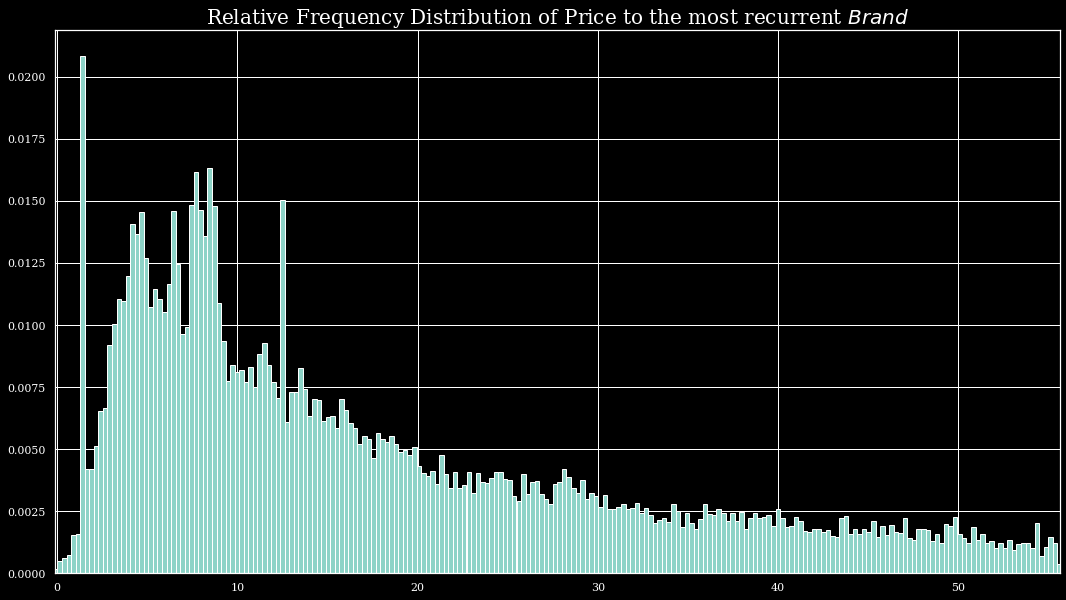

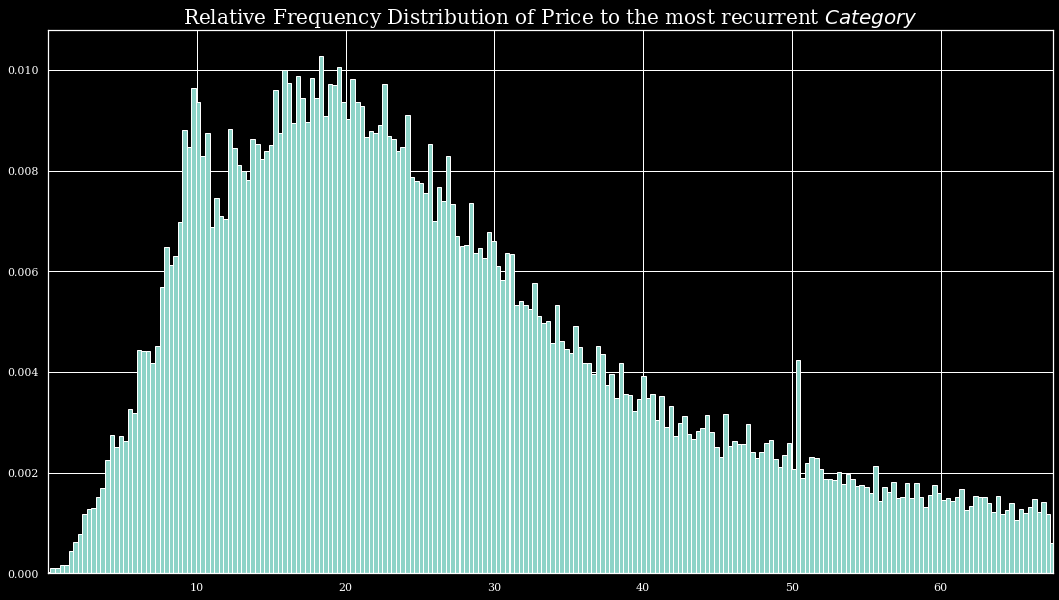

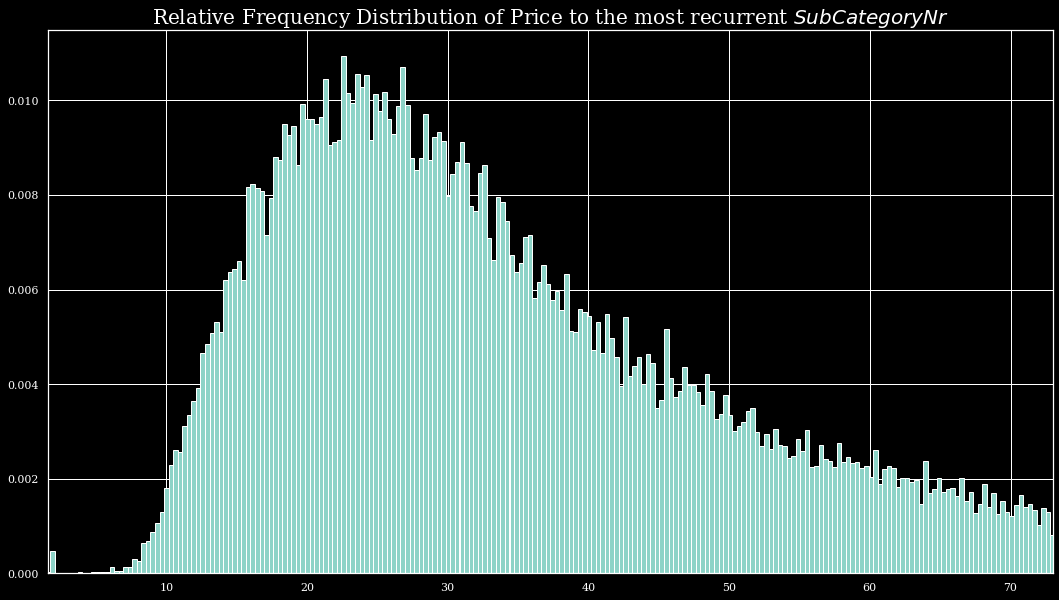

In [ ]:
def outliers_killer(data, m = 3.5):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

def plot_step(df, col, chart='RF'):
  df = pd.read_csv('test_price.csv')
  df_top = df.groupby([col])[col].count().nlargest(1).index
  df_prices = df[df[col] == df_top[0]]['SellPrice'].values
  df_plot = outliers_killer(df_prices)
  rf = stats.relfreq(df_plot, numbins=222)
  x = rf.lowerlimit + np.linspace(0, rf.binsize*rf.frequency.size, rf.frequency.size)

  fig = plt.figure(figsize=(18, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.bar(x, rf.frequency, width=rf.binsize)
  ax.set_title(f'Relative Frequency Distribution of Price to the most recurrent ${col}$', fontsize=20)
  ax.set_xlim([x.min(), x.max()])

plot_step(df, 'Brand')
plot_step(df, 'Category')
plot_step(df, 'SubCategoryNr')


5. Сделать сегментацию по уровням цен по иерархии (внутри Brand/Category/SubCategory)
* Дополнительные знания найденные в датасете и инсайты приветствуются.
